In [1]:
from pypropagate import *
import matplotlib.pyplot as plt
from pypropagate.coordinate_ndarray import CoordinateNDArray
from pypropagate.plot import get_metric_prefix,get_unitless_bounds
from matplotlib.colors import LogNorm
%matplotlib inline

## Define the gaussian beam

In [4]:
settings = presets.create_paraxial_wave_equation_settings()
s = settings.symbols
pde = settings.partial_differential_equation

g = settings.create_category('gaussian',info='Parameters of the gaussian beam')
g.create_symbol('w_0',info = 'Waist size at z = 0',type=pc.Types.Real,positive=True)
g.create_function('w_r',(s.z,),pc.sqrt(2)*pc.sqrt((g.w_0)**2/2+2*pde.A*s.z),info = 'Waist size')
g.create_function('u',(s.x,s.y,s.z),(g.w_0)**2/g.w_r**2*pc.exp(pde.F*s.z-(s.x**2+s.y**2)/(g.w_r**2)))

settings.get_definition(g.u).subs(pde.F,0).evaluate()

exp(-(x**2+y**2)/w_r_gaussian(z)**2)*w_0_gaussian**2*(1/w_r_gaussian(z))**2

## Set simulation parameters

In [3]:
g.w_0 = 0.25*units.um
s.n = 1
s.u0 = g.u
s.u_boundary = g.u
settings.wave_equation.set_energy(12*units.keV)

In [4]:
sz = 400 * units.mm
sxy = 204 * units.um

s.xmin,s.xmax = -sxy/2, sxy/2
s.ymin,s.ymax = -sxy/2, sxy/2
s.zmin,s.zmax = -sz/2, sz/2
s.Nx,s.Ny,s.Nz = 4096,4096,500

## Fresnel Solution

In [5]:
propagator = propagators.FresnelPropagator2D(settings)
fieldfr = propagator.run_slice()[:,0]


Simulation running. Step 500/500: 100% [████████████████████████] [568.1 s] [eta 0s +- 0s]


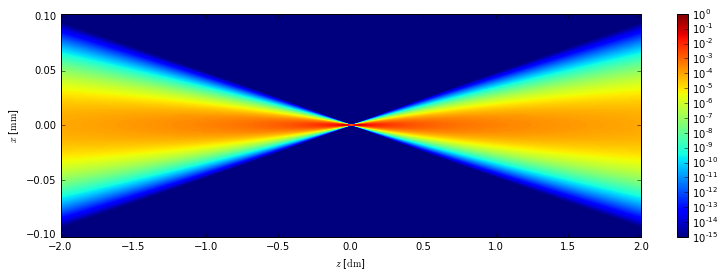

In [6]:
plot(fieldfr,figsize=(13,4),norm=LogNorm(vmin=10**-15, vmax=1));

### Compare to analytical solution

In [7]:
fieldan = expression_to_array(g.u.subs(s.y,0),settings)
print "max deviation from analytical solution: %s" % abs(fieldan - fieldfr).max()

max deviation from analytical solution: 0.00936957381781


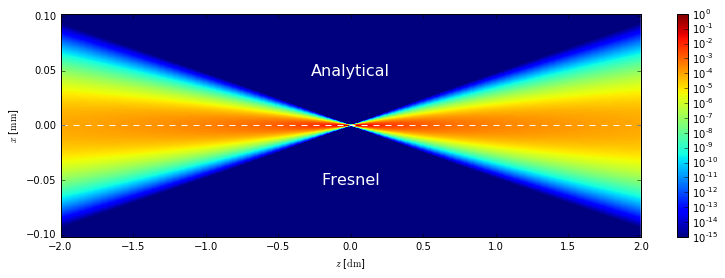

In [8]:
split_data = np.append(fieldfr[:0].data[::2,:],fieldan[0:].data[::2,:],axis=0)
split_field = CoordinateNDArray(split_data,fieldan.bounds,fieldan.axis,fieldan.evaluate)
plt.figure(figsize=(13,4))

text_settings={'color':'w','ha':'center','va':'center','size':16}

plt.plot([-2,2],[0,0],'w--')
plt.text(0,0.05,"Analytical",text_settings)
plt.text(0,-0.05,'Fresnel',text_settings)
im = plot(split_field+10**-16,ax=plt.gca(),norm=LogNorm(vmin=10**-15, vmax=1),interpolation='none')

plt.colorbar(im)
plt.show()

## Finite Differences Solution

In [9]:
small_settings = settings.copy()
s = small_settings.symbols

In [10]:
sxy = 8 * units.um

s.xmin,s.xmax = -sxy/2, sxy/2
s.ymin,s.ymax = -sxy/2, sxy/2
s.Nx = s.Ny = 1000
s.Nz = 10000


Simulation running. Step 10000/10000: 100% [████████████████████] [665.2 s] [eta 0s +- 0s]


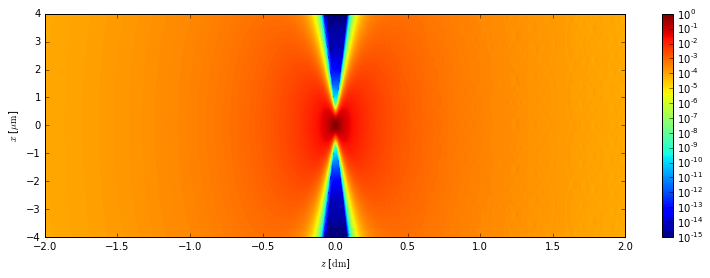

In [11]:
propagator = propagators.FiniteDifferencesPropagator2D(small_settings)
fieldfd2 = propagator.run_slice()[::,0]
plot(fieldfd2,norm=LogNorm(vmin=10**-15, vmax=1),figsize=(13,4));

## Compare to analytical solution

In [12]:
fieldan2 = expression_to_array(g.u.subs(s.y,0),small_settings)
print "max deviation from analytical solution: %s" % abs(fieldan2 - fieldfd2).max()

max deviation from analytical solution: 0.00730377606527


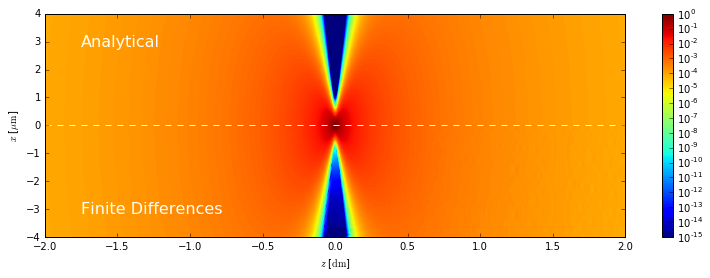

In [13]:
split_data2 = np.append(fieldfd2[:0].data[::2,::2],fieldan2[0:].data[::2,::2],axis=0)
split_field2 = CoordinateNDArray(split_data2,fieldan2.bounds,fieldan2.axis,fieldan2.evaluate)
plt.figure(figsize=(13,4))

text_settings={'color':'w','ha':'left','va':'center','size':16}

plt.plot([-2,2],[0,0],'w--')
plt.text(-1.75,3,"Analytical",text_settings)
plt.text(-1.75,-3,'Finite Differences',text_settings)
im = plot(split_field2+10**-16,ax=plt.gca(),norm=LogNorm(vmin=10**-15, vmax=1),interpolation='none')

plt.colorbar(im)
plt.show()

## Plot from the paper

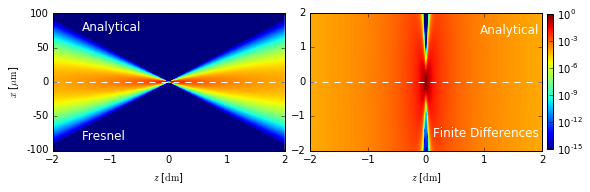

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(8,2.5)) 
gs = mpl.gridspec.GridSpec(1, 3, width_ratios=[20, 20, 1]) 
ax1,ax2 = [plt.subplot(gs[i]) for i in range(2)]

text_settings={'color':'w','ha':'left','va':'center','size':12}

ax1.plot([-2,2],[0,0],'w--')
ax1.text(-1.5,0.08,"Analytical",text_settings)
ax1.text(-1.5,-0.08,'Fresnel',text_settings)
im = plot(split_field+10**-16,ax=ax1,norm=LogNorm(vmin=10**-15, vmax=1),interpolation='none')


ax1.xaxis.set_ticks(range(-2,3))
ax1.set_ylabel('$x$ [$\mu \mathrm{m}$]')
ax1.yaxis.set_ticklabels([50*i for i in range(-3,3)])


im = plot(split_field2+10**-16,ax=ax2,vmax=1,norm=LogNorm(vmin=10**-15, vmax=1),interpolation='none')
ax2.yaxis.label.set_text('')

text_settings={'color':'w','ha':'right','va':'center','size':12}

ax2.plot([-2,2],[0,0],'w--')
ax2.text(1.95,1.5,"Analytical",text_settings)
ax2.text(1.95,-1.5,'Finite Differences',text_settings)

ax2.set_ylim(-2,2)
ax2.set_yticks(range(-2,3))
ax2.set_xticks(range(-2,3))


plt.tight_layout(pad=0.3)

cbaxes = fig.add_axes([0.94, 0.2, 0.01, 0.75])

cbar = fig.colorbar(im,cax=cbaxes)
cbar.set_ticks([10**-(3*i) for i in range(6)])

#plt.savefig('analytical_gauss_fdfr.pdf')


plt.show()